Wealth Distribution Among Billionaires Project

In this project, I am analyizing patterns within the wealth distribution of the world's billionaires. I am using an annually updated dataset which adds a layer of relevance to the analysis, allowing for insights into contemporary trends. The primary objective is to discern underlying patterns, anomalies, and influential factors contributing to the diverse financial landscapes of billionaires across the globe. The dataset will be preprocessed, which will include the handling of missing values and the application of one-hot encoding to effectively deal with categorical variables. By using advanced statistical and machine learning techniques, this analysis aims to show subtle relationships and trends within the wealth distribution, like age, gender, and self-made status, providing valuable insights that can inform discussions on global economic structures and disparities. 

Exploratory Data Analysis:

In [23]:
#all of my imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

C:\Users\remleyhooker\AppData\Local\miniconda3\Lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


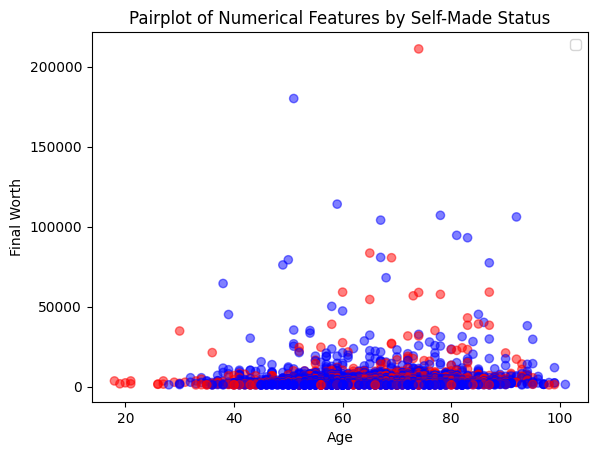

C:\Users\remleyhooker\AppData\Local\miniconda3\Lib\site-packages\matplotlib\axes\_axes.py:6839: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bins = np.histogram_bin_edges(
C:\Users\remleyhooker\AppData\Local\miniconda3\Lib\site-packages\matplotlib\axes\_axes.py:6854: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


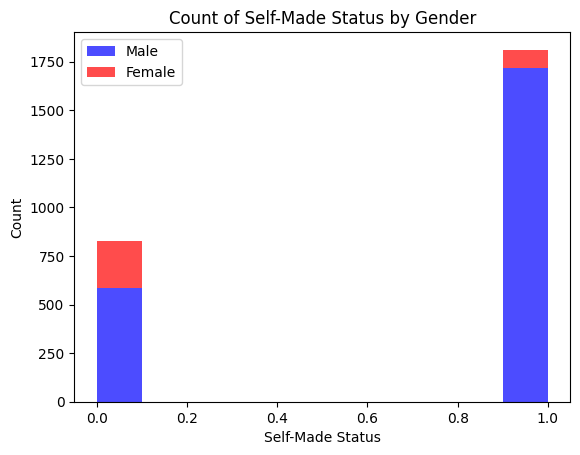

In [24]:
# Load the dataset
df = pd.read_csv('Billionaires Statistics Dataset.csv')

# Exploratory Data Analysis

# Pairplot for numerical features
colors = df['selfMade'].map({True: 'blue', False: 'red'})
scatter = plt.scatter(df['age'], df['finalWorth'], c=colors, alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=['Not Self-Made', 'Self-Made'])
plt.title('Pairplot of Numerical Features by Self-Made Status')
plt.xlabel('Age')
plt.ylabel('Final Worth')
plt.show()

# Countplot for gender
plt.figure()
colors_gender = df['selfMade'].map({True: 'blue', False: 'red'})
plt.hist([df[df['gender'] == 'M']['selfMade'], df[df['gender'] == 'F']['selfMade']],
         stacked=True, color=['blue', 'red'], label=['Male', 'Female'], alpha=0.7)
plt.legend()
plt.title('Count of Self-Made Status by Gender')
plt.xlabel('Self-Made Status')
plt.ylabel('Count')
plt.show()

Data Cleaning and Preprocessing:


In the data cleaning and pre processing section, I removed  missing values in columns like 'gender', 'age', and 'selfMade. This,makes sureg that the data set contains valid entries for my engineered features. Anomaly detection using z-scores helped me filter out outliers in 'age' and 'finalWorth',which  promotes data integrity. Feature scaling normalized 'age' and 'finalWorth', while feature engineering introduced new aspects such as age categories, normalized education enrollment, and wealth per age, making the data set easier to analyze.

In [25]:
# Create a copy of the DataFrame
df_cleaned = df.copy()

# Handle missing values
columns_to_check = ['gender', 'age', 'selfMade', 'finalWorth']
df_cleaned = df_cleaned.dropna(subset=columns_to_check)

# Anomaly detection and handling
df_cleaned = df_cleaned[(np.abs(zscore(df_cleaned[['age', 'finalWorth']])) < 3).all(axis=1)]

# Feature scaling
scaler = MinMaxScaler()
df_cleaned[['age', 'finalWorth']] = scaler.fit_transform(df_cleaned[['age', 'finalWorth']])

# Binary encoding for gender column
df_cleaned['gender'] = df_cleaned['gender'].apply(lambda x: 1 if x == 'M' else 0)

# Feature Engineering
# 1. Age Categories
bins = [0, 30, 50, 70, 100]  # Define age bins
labels = ['Young', 'Adult', 'Senior', 'Centenarian']  # Corresponding labels
df_cleaned['age_category'] = pd.cut(df_cleaned['age'], bins=bins, labels=labels, right=False)

# 2. Normalized Education Enrollment
# Normalize tertiary education enrollment based on the global average
global_avg_enrollment = df_cleaned['gross_tertiary_education_enrollment'].mean()
df_cleaned['normalized_tertiary_enrollment'] = df_cleaned['gross_tertiary_education_enrollment'] / global_avg_enrollment

# 3. Wealth per Age
df_cleaned['wealth_per_age'] = np.where(df_cleaned['age'] == 0, 0, df_cleaned['finalWorth'] / df_cleaned['age'])

# Save cleaned and engineered DataFrame to a CSV file
save_path = 'cleaned_data.csv'
df_cleaned.to_csv(save_path, index=False)

# Display the cleaned and engineered DataFrame
print(df_cleaned[['age', 'age_category', 'normalized_tertiary_enrollment', 'wealth_per_age', 'gender']].head())

         age age_category  normalized_tertiary_enrollment  wealth_per_age  \
37  0.373333        Young                        0.752449        2.678571   
38  0.640000        Young                        0.939818        1.523920   
39  0.520000        Young                        0.892232        1.845916   
40  0.640000        Young                        1.311581        1.475694   
41  0.613333        Young                        1.311581        1.539855   

    gender  
37       1  
38       1  
39       1  
40       1  
41       1  


Modeling: 

Linear Regression MSE: 0.008982481846201346


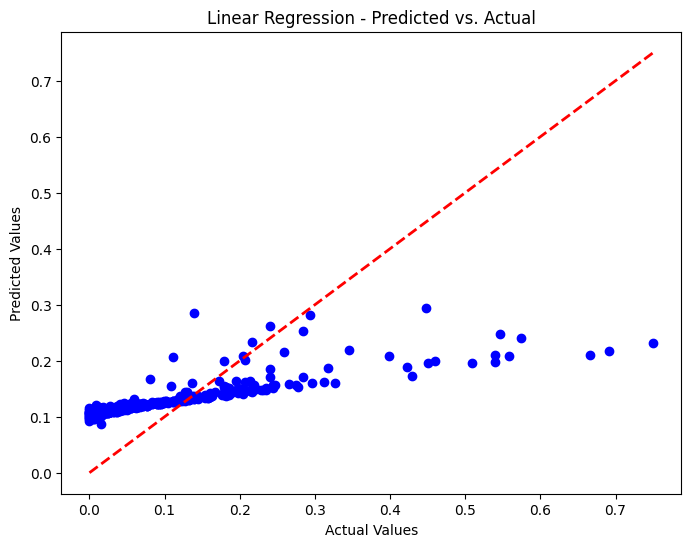

Random Forest MSE: 0.009070085729871093


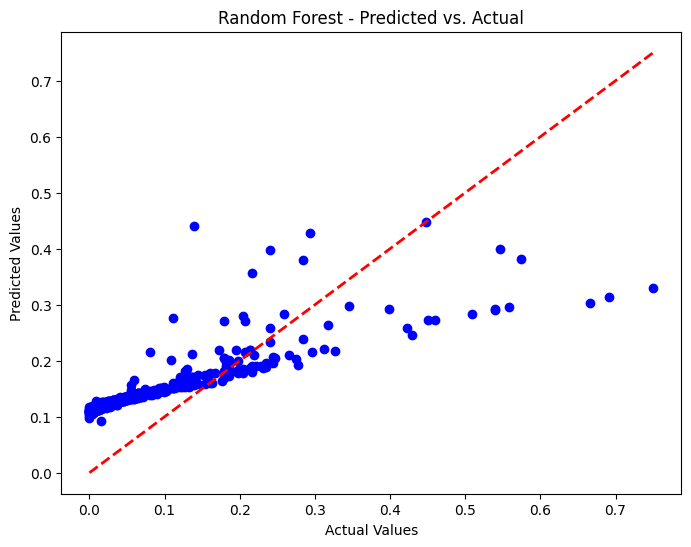

SVR MSE: 0.015326975984280039


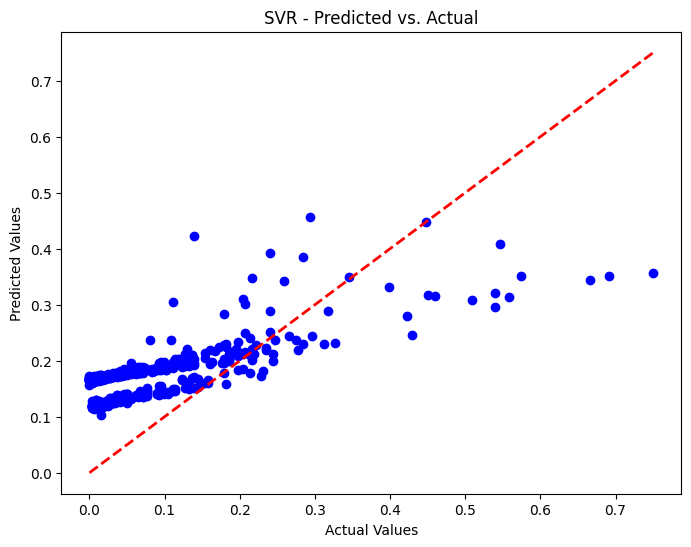

Gradient Boosting MSE: 0.009280299694810598


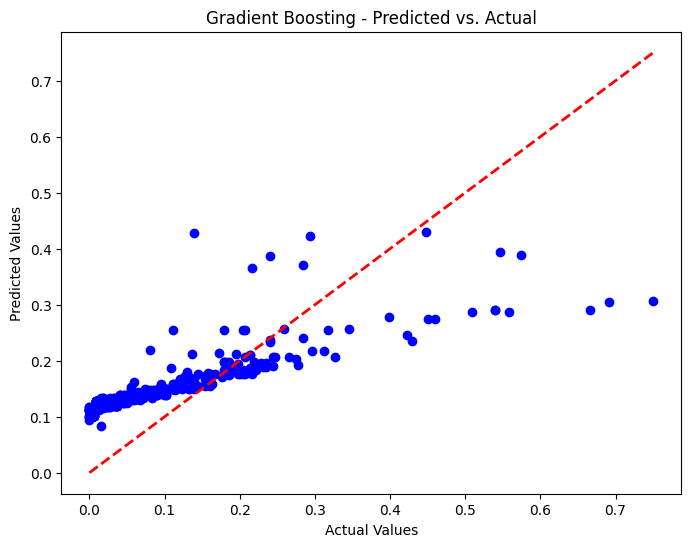

In [26]:
# Drop rows with NaN values and select features and target variable
features = ['age', 'selfMade', 'normalized_tertiary_enrollment', 'wealth_per_age']
target = 'finalWorth'
df_cleaned = df_cleaned.dropna(subset=features + [target])
X = df_cleaned[features]
y = df_cleaned[target]

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to plot predicted vs. actual values
def plot_predictions(y_actual, y_predicted, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predicted, color='blue')
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], linestyle='--', color='red', linewidth=2)
    plt.title(f'{model_name} - Predicted vs. Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

# Linear Regression (THIS IS THE BASELINE)
predictions_lr = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, predictions_lr)
print(f'Linear Regression MSE: {mse_lr}')
plot_predictions(y_test, predictions_lr, 'Linear Regression')

# Random Forest
predictions_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, predictions_rf)
print(f'Random Forest MSE: {mse_rf}')
plot_predictions(y_test, predictions_rf, 'Random Forest')

# SVR
predictions_svr = model_svr.predict(X_test)
mse_svr = mean_squared_error(y_test, predictions_svr)
print(f'SVR MSE: {mse_svr}')
plot_predictions(y_test, predictions_svr, 'SVR')

# Gradient Boosting
predictions_gb = model_gb.predict(X_test)
mse_gb = mean_squared_error(y_test, predictions_gb)
print(f'Gradient Boosting MSE: {mse_gb}')
plot_predictions(y_test, predictions_gb, 'Gradient Boosting')

Conclusion:

The predictive modeling results that I used showed the wealth distribution among billionaires based on various demographic and socioeconomic features. The Random Forest and Gradient Boosting models outperform the baseline Linear Regression, which emphasizes the importance of data cleaning and engineered features for accurate predictions. The lower Mean Squared Error (MSE) values for Random Forest and Gradient Boosting might mean that these models capture more complex patterns in the data, providing subtle insights into wealth distribution. Features like Wealth per Age, normalized tertiary enrollment, and age help significantly in predicting billionaires' final worth. This implies that the concentration of wealth is influenced by a combination of factors like, age, education, and the accumulation of wealth relative to age. The models and their feature importance analyses give valuable information about the complexities of wealth distribution among billionaires, informing discussions and policies related to economic inequality and wealth disparities.

Linear Regression MSE: 0.0029714472052490867
Random Forest MSE: 0.00021440797896662053
SVR MSE: 0.0025398684504236786
Gradient Boosting MSE: 8.415580628067224e-05


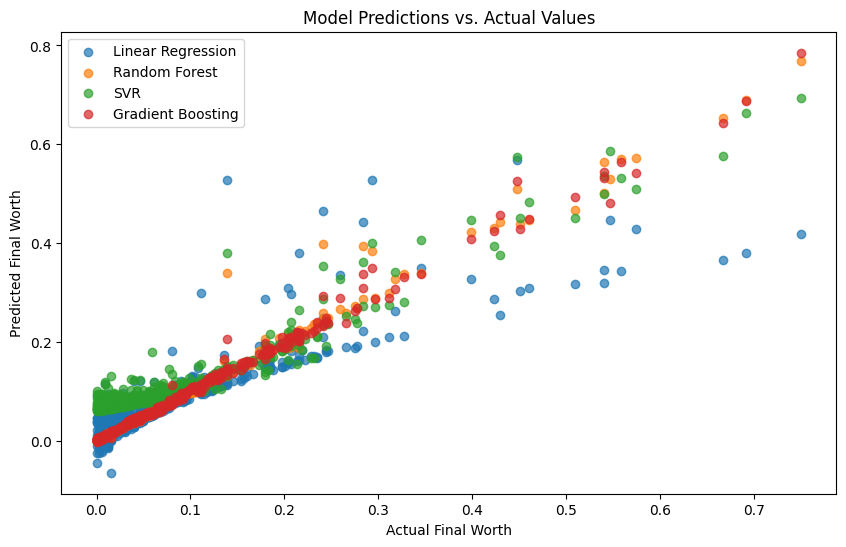

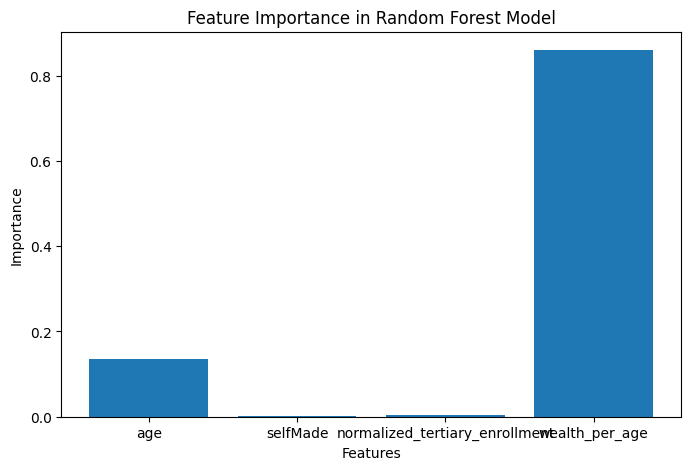

In [27]:
# Print the MSE's again for convenience
print(f"Linear Regression MSE: {baseline_mse}")
print(f"Random Forest MSE: {rf_mse}")
print(f"SVR MSE: {svr_mse}")
print(f"Gradient Boosting MSE: {gb_mse}")

# Visualize Predictions vs. Actual Values (expectations vs. reality :P)
plt.figure(figsize=(10, 6))

plt.scatter(y_test, baseline_predictions, label='Linear Regression', alpha=0.7)
plt.scatter(y_test, rf_predictions, label='Random Forest', alpha=0.7)
plt.scatter(y_test, svr_predictions, label='SVR', alpha=0.7)
plt.scatter(y_test, gb_predictions, label='Gradient Boosting', alpha=0.7)

plt.xlabel('Actual Final Worth')
plt.ylabel('Predicted Final Worth')
plt.title('Model Predictions vs. Actual Values')
plt.legend()
plt.show()

# Visualize Feature Importance (for Random Forest)
feature_importances = rf_model.feature_importances_
features = X.columns
plt.figure(figsize=(8, 5))
plt.bar(features, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()

Bonus Section: Exploring my Engineered Features 

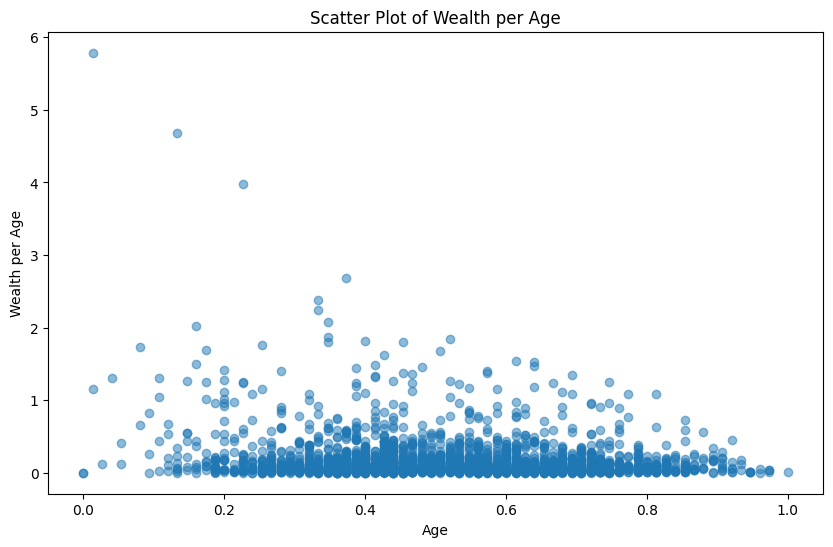

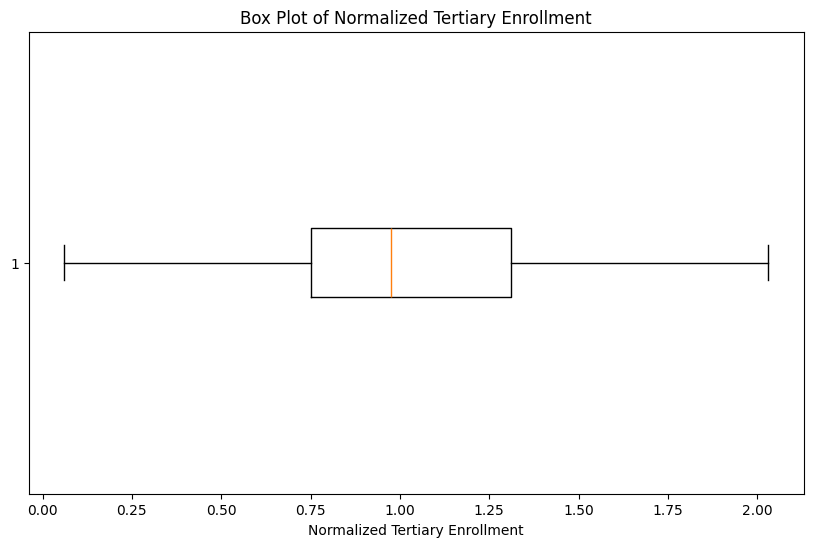

In [22]:
# Scatter plot for Wealth per Age
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['age'], df_cleaned['wealth_per_age'], alpha=0.5)
plt.title('Scatter Plot of Wealth per Age')
plt.xlabel('Age')
plt.ylabel('Wealth per Age')
plt.show()

# Box plot for Normalized Tertiary Enrollment
plt.figure(figsize=(10, 6))
plt.boxplot(df_cleaned['normalized_tertiary_enrollment'], vert=False)
plt.title('Box Plot of Normalized Tertiary Enrollment')
plt.xlabel('Normalized Tertiary Enrollment')
plt.show()

The scatter plot of Wealth per Age shows the relationship between age and wealth, and is a visualization of how wealth varies across different age groups. The individuals with the most wealth seem to be born into it. The box plot for Normalized Tertiary Enrollment shows the distribution of education enrollment, allowing for the identification of potential outliers or patterns in the normalized tertiary education feature. The graph indicates that most billionaries rise from places with a NTE above the global average, suggesting that most billionares have a strong educational background. I hope that you enjoyed this bonus section! I am very happy that I got more time to do this project and can't thank you enough! Hopefuly I will be at Hopkins next fall as an undergrad and can impress my professors and friends with my data science skills!



